In [1]:
import pymolpro

p = pymolpro.Project('N2')
p.write_input(r"""
!memory,1.5,g
gthresh,energy=1e-10
basis,cc-pVDZ
set,cc_norm_max=1e99
r=[1,1.2,1.4,1.6,1.8,2, 2.1, 2.2] angstrom
geometry={N;N,N,r(i)}
do i=1,#r
rhf
erhf(i)=energy
mp2
ermp2(i)=energy
mp3
ermp3(i)=energy
mp4
ermp4(i)=energy
{ccsd(t),maxit=500,shiftp=.4}
eccsd(i)=energc,eccsdt(i)=energy
papt;mp2
erpapt2(i)=energy
papt;mp3
erpapt3(i)=energy
papt;mp4
erpapt4(i)=energy
{ccsd(t),maxit=500,shiftp=.4}
eccsdp(i)=energc,eccsdpt(i)=energy
fci
efci(i)=energy
enddo
put,xml
""")
p.run(wait=False)


In [2]:
print(p.out)


 Working directory              : /var/folders/2v/xbgp75_9785319ghcgb4zr4r0000gp/T//molpro.4z2lbQHPry/
 Global scratch directory       : /var/folders/2v/xbgp75_9785319ghcgb4zr4r0000gp/T//molpro.4z2lbQHPry/
 Wavefunction directory         : /Users/sacpjk/wfu/
 Main file repository           : /var/folders/2v/xbgp75_9785319ghcgb4zr4r0000gp/T//molpro.4z2lbQHPry/

 id        : peterk

 Nodes                        nprocs
 Cardiff-University-G34YLXT77Y    1
 GA implementation: MPI file
 GA implementation (serial work in mppx): MPI file

 Using customized tuning parameters: mindgm=1; mindgv=20; mindgc=4; mindgr=1; noblas=0; minvec=7
 default implementation of scratch files=df  


 Variables initialized (1037), CPU time= 0.00 sec
 
                                                                                 !memory,1.5,g
 gthresh,energy=1e-10
 basis,cc-pVDZ
 set,cc_norm_max=1e99
 r=[1,1.2,1.4,1.6,1.8,2, 2.1, 2.2] angstrom
 geometry={N;N,N,r(i)}
 do i=1,#r
 rhf
 erhf(i)=energy
 mp2
 ermp2

In [3]:
p.run(wait=True)

In [4]:
if not pymolpro.no_errors([p]): print(p.out)

In [5]:
def plotter(x: list, data: dict, xlim=None, ylim=None, aspect_ratio=None, legend_loc='best', formats: dict = {}, legend_to_anchor=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.interpolate import InterpolatedUnivariateSpline
    fig, ax = plt.subplots()
    xfine = np.linspace(np.array(x).min(), np.array(x).max(), 2000)
    for k, v in data.items():
        assert len(x) == len(v)
        if k in formats.keys():
            # ax.plot(x, v, formats[k], label=k)
            ax.plot(xfine, InterpolatedUnivariateSpline(x, np.array(v))(xfine), formats[k], label=k)
        else:
            # ax.plot(x, v, label=k)
            ax.plot(xfine, InterpolatedUnivariateSpline(x, np.array(v))(xfine), label=k)
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    if aspect_ratio:
        xl, xr = ax.get_xlim()
        yl, yr = ax.get_ylim()
        ax.set_aspect(abs((xr - xl) / (yr - yl)) * aspect_ratio)
    if legend_to_anchor:
        ax.legend(bbox_to_anchor=legend_to_anchor)
    else:
        ax.legend(loc=legend_loc)
    return fig, ax

In [10]:
def plotall(filename=None, xlim=None, ylim=None, legend_loc='best', omit=[], aspect_ratio=None, **kwargs):
    datasets = {
        'FCI': p.variable('efci'),
        'HF': p.variable('eRHF'),
        # 'UHF': p.variable('eUHF'),
        'MP2': p.variable('eRMP2'),
        # 'UMP2': p.variable('eUMP2'),
        'MP3': p.variable('eRMP3'),
        # 'UMP3': p.variable('eUMP3'),
        'MP4': p.variable('eRMP4'),
        # 'UMP4': p.variable('eUMP4'),
        'PAPT2': p.variable('eRPAPT2'),
        # 'UPAPT2': [float(e) for e in p.xpath('//jobstep[@command="PLUGIN"]/property[@name="PAPT2"]/@value')],
        'PAPT3': p.variable('eRPAPT3'),
        # 'UPAPT3': [float(e) for e in p.xpath('//jobstep[@command="PLUGIN"]/property[@name="PAPT3"]/@value')],
        'PAPT4': p.variable('eRPAPT4'),
        'CCSD': p.variable('eCCSD'),
        # 'CCSDP': p.variable('eCCSDP'),
        'CCSD(T)': p.variable('eCCSDT'),
        'CCSD(PAPT-T)': p.variable('eCCSDPT'),
    }
    fig, ax = plotter(p.variable('r'), {k: v for k, v in datasets.items() if k not in omit},
                      ylim=ylim,
                      xlim=xlim,
                      aspect_ratio=aspect_ratio,
                      formats={'FCI': 'k',
                               'HF': 'g', 'UHF': 'g--',
                               'MP2': 'r', 'UMP2': 'r--',
                               'MP3': 'y', 'UMP3': 'y--',
                               'MP4': 'c', 'UMP4': 'c--',
                               'PAPT2': 'r-.', 'UPAPT2': 'r:',
                               'PAPT3': 'y-.', 'UPAPT3': 'y:',
                               'PAPT4': 'c-.', 'UPAPT4': 'c:',
                               'CCSD': 'm',
                               'CCSD(T)': 'b', 'CCSD(PT)': 'b-.',
                               },
                      legend_loc=legend_loc,
                       **kwargs)
    if filename: fig.savefig(filename + '.pdf', bbox_inches='tight', pad_inches=0, transparent=True)
    return fig, ax


In [11]:
p.variable('eccsd'), p.variable('eccsdp')

([-109.217788417483,
  -109.247057518938,
  -109.14517890569,
  -109.034728223644,
  -108.950833404297,
  -108.909520684783,
  -108.91004351121,
  -108.922556938995],
 [-109.217788417472,
  -109.247057518929,
  -109.145178905684,
  -109.034728223673,
  -108.950833404308,
  -108.909520684713,
  -108.910043511293,
  -108.922556938957])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

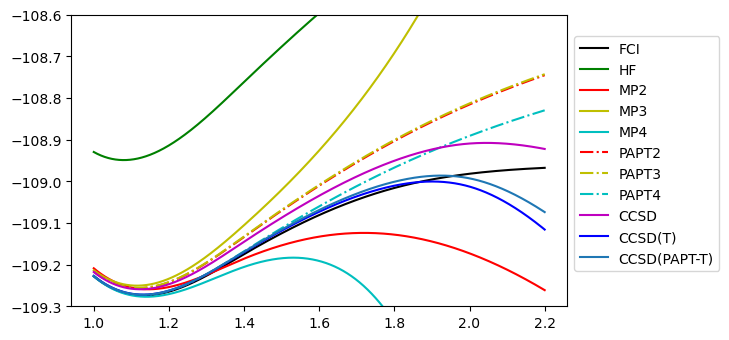

In [12]:
plotall(filename='N2',
        legend_loc='lower left',
        aspect_ratio=1/1.7,
        ylim=[-109.3, -108.6],
        # xlim=[.5, 3],
        # omit=['UPAPT2','UPAPT3','RPAPT2','RPAPT3','RPAPT4'],
        # ,aspect_ratio=1/1.7,
        legend_to_anchor=(1,.95),
        )